# Loading images in Tensorflow

The recommended way of loading files into Tensorflow is as a TFRecords file.

I ripped all of this code from http://machinelearninguru.com/deep_learning/tensorflow/basics/tfrecord/tfrecord.html.

## List images and their labels

Load all the images from the dataset directory and generate labels for each one. The dataset is pulled from Kaggle: https://www.kaggle.com/c/dogs-vs-cats

Each image is labeled in a separate list and then run through a stable shuffle, then split into 60% training, 20% validation, and 20% testing sets.

In [2]:
# Some setup
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from random import shuffle
import glob
import cv2
import tensorflow as tf
import sys

shuffle_data = True
cat_dog_train_path = "../Datasets/dogs_and_cats/*.jpg"

# Read addresses and labels from folder
addrs = glob.glob(cat_dog_train_path)
labels = [0 if "cat" in addr else 1 for addr in addrs]

# Shuffle data
if shuffle_data:
    c = list(zip(addrs, labels))
    shuffle(c)
    addrs, labels = zip(*c)

# Divide the data into 60% training, 20% validation, and 20% test
train_addrs = addrs[0:int(0.6 * len(addrs))]
train_labels = labels[0:int(0.6 * len(labels))]

val_addrs = addrs[int(0.6 * len(addrs)):int(0.8 * len(addrs))]
val_labels = labels[int(0.6 * len(labels)):int(0.8 * len(labels))]

test_addrs = addrs[int(0.8 * len(addrs)):]
test_labels = labels[int(0.8 * len(labels)):]

print("train_addrs size: {}".format(len(train_addrs)))
print("train_labels size: {}".format(len(train_labels)))
print("val_addrs size: {}".format(len(val_addrs)))
print("val_labels size: {}".format(len(val_labels)))
print("test_addrs size: {}".format(len(test_addrs)))
print("test_labels size: {}".format(len(test_labels)))

train_addrs size: 15000
train_labels size: 15000
val_addrs size: 5000
val_labels size: 5000
test_addrs size: 5000
test_labels size: 5000


## Convert images to a usable format

Next we load the images with OpenCV and convert them to a float32, which we'll save to the TFRecords file

In [4]:
def load_image(addr):
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

Now we put the data into a protocol buffer called `Example`. This protobuf is serialized to a string and written to a TFRecords file. The protobuf contains the protocol `Features`.

1) Open a TFRecords file with `tf.python_io.TFRecordWriter`

2) Convert data to proper data type

3) Create feature using `tf.train.Feature`

4) Create protobuf with `tf.train.Example`

5) Serialize `Example` to string

6) Write out the protobuf to a TFRecords file

In [7]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# Why can't I use this?
def _float32_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [8]:
# Write out TFRecords files
def write_tfrecords(tfr_filename, addrs, labels, feature_name):
    """
    Write TFRecords file to disk from input data.
    
    Inputs:
        tfr_filename: output filename
        addrs: input images
        labels: input labels
        feature_name: train, test, or val.
    """
    writer = tf.python_io.TFRecordWriter(tfr_filename)
    for i in range(len(addrs)):
        # print how many images are saved every 1000 images
        if not i % 1000:
            print('{0} data: {1}/{2}'.format(feature_name, i, len(addrs)))
            sys.stdout.flush()
        # Load the image
        img = load_image(addrs[i])
        label = labels[i]
        # Create a feature
        feature = {feature_name + '/label': _int64_feature(label),
                   feature_name + '/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    writer.close()
    sys.stdout.flush()
    
# Write training data
write_tfrecords('train.tfrecords', train_addrs, train_labels, 'train')
# Write validation data
write_tfrecords('val.tfrecords', val_addrs, val_labels, 'val')
# Write test data
write_tfrecords('test.tfrecords', test_addrs, test_labels, 'test')

train data: 0/15000
train data: 1000/15000
train data: 2000/15000
train data: 3000/15000
train data: 4000/15000
train data: 5000/15000
train data: 6000/15000
train data: 7000/15000
train data: 8000/15000
train data: 9000/15000
train data: 10000/15000
train data: 11000/15000
train data: 12000/15000
train data: 13000/15000
train data: 14000/15000
val data: 0/5000
val data: 1000/5000
val data: 2000/5000
val data: 3000/5000
val data: 4000/5000
test data: 0/5000
test data: 1000/5000
test data: 2000/5000
test data: 3000/5000
test data: 4000/5000


## Read TFRecords File

Now we read the TFRecords file by loading the training data in batches.

- *Create a list of file names* - We just have one training file in this case
- *Create a queue to hold filenames* using `tf.train.string_input_producer`. This holds files in a FIFO queue.
- *Define a reader* with `tf.TFRecordReader`
- *Define a decoder* which decodes the record read by the reader.
- *Convert the data from strings back to numbers* using `tf.decode_raw(bytes, out_type)`
- *Reshape the data into its original shape* using `tf.reshape`
- Then you can do preprocessing and batching as desired.

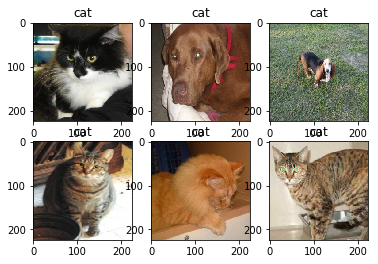

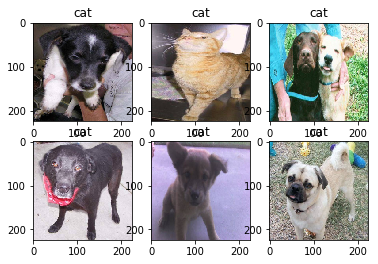

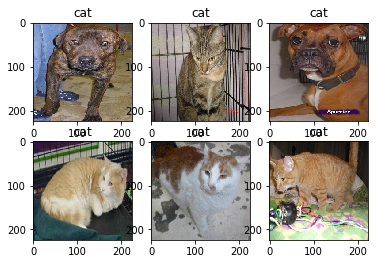

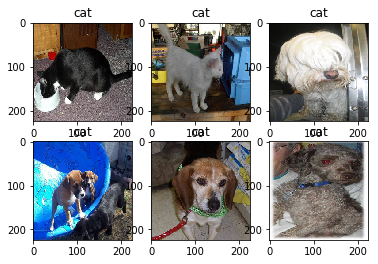

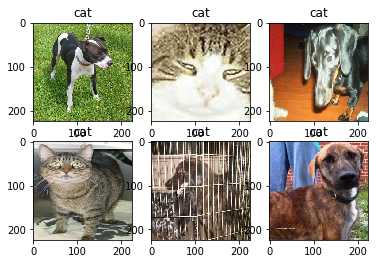

In [9]:
data_path = 'train.tfrecords'  # address to save the hdf5 file
with tf.Session() as sess:
    feature = {'train/image': tf.FixedLenFeature([], tf.string),
               'train/label': tf.FixedLenFeature([], tf.int64)}
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['train/image'], tf.float32)
    
    # Cast label data into int32
    label = tf.cast(features['train/label'], tf.int32)
    # Reshape image data into the original shape
    image = tf.reshape(image, [224, 224, 3])
    
    # Any preprocessing here ...
    
    # Creates batches by randomly shuffling tensors
    images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)
    
     # Initialize all global and local variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for batch_index in range(5):
        img, lbl = sess.run([images, labels])
        img = img.astype(np.uint8)
        for j in range(6):
            plt.subplot(2, 3, j+1)
            plt.imshow(img[j, ...])
            plt.title('cat' if lbl[j]==0 else 'dog')
        plt.show()
    # Stop the threads
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)
    sess.close()

*But why do they all say "cat"?*